The "Lung Opacity (Non-COVID lung infection)" directory serves as a catch-all category for lung images exhibiting abnormal densities due to various infections and diseases other than COVID-19. This distinction is crucial for accurate disease classification and the development of effective diagnostic tools.

In [55]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf

Total images loaded: 21165
x_train shape: (16932, 64, 64, 1), y_train shape: (16932,)
x_test shape: (4233, 64, 64, 1), y_test shape: (4233,)


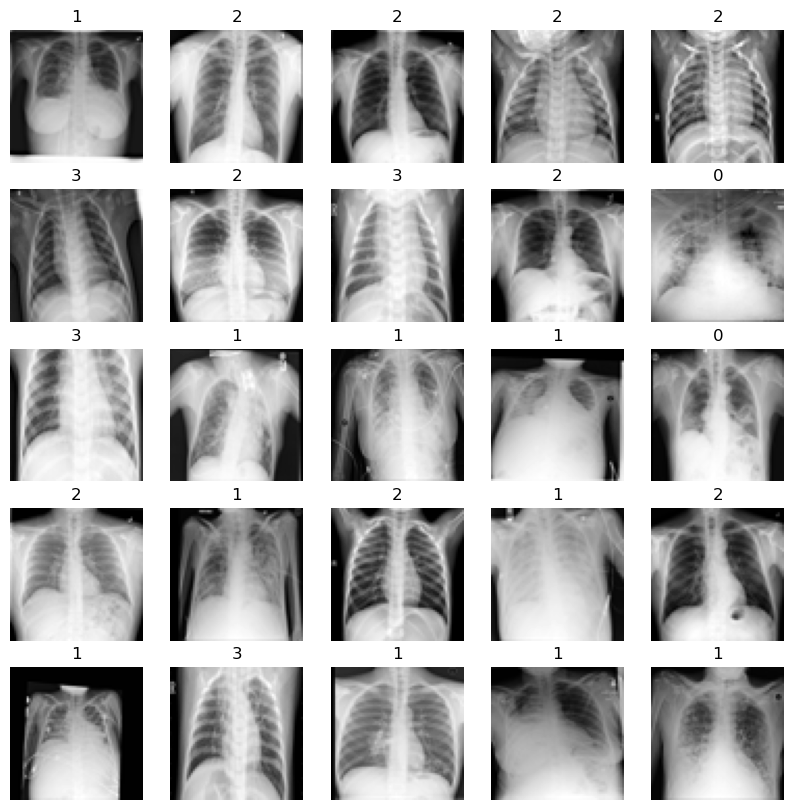

In [57]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Define the dataset directory and image size
dataset_dir = '/Users/freewheelin/Downloads/kagglehub/covid19_radiography_dataset' 
IMG_SIZE = 64  # Size to which the images will be resized

# Define the class labels (map folder names to numeric labels)
class_labels = {
    'covid': 0,
    'lung_opacity': 1,
    'normal': 2,
    'viral_pneumonia': 3
}

images = []  # List to store image data
labels = []  # List to store the corresponding labels

# Loop through each class folder and its subdirectory "images"
for class_name, label in class_labels.items():
    sub_dir = os.path.join(dataset_dir, class_name, 'images')
    
    if os.path.exists(sub_dir):
        for filename in os.listdir(sub_dir):
            img_path = os.path.join(sub_dir, filename)
            
            # Only process valid image files
            if img_path.endswith(('.jpeg', '.jpg', '.png')):
                try:
                    # Open and resize the image
                    img = Image.open(img_path)
                    img = img.resize((IMG_SIZE, IMG_SIZE))  # Resize to 64x64
                    img = img.convert('L')  # Convert to grayscale (L mode)
                    img_array = np.array(img)  # Convert to numpy array

                    # Append the image and its label
                    images.append(img_array)
                    labels.append(label)
                except Exception as e:
                    print(f"Error loading image {img_path}: {e}")
    else:
        print(f"Directory {sub_dir} not found.")

# Convert to numpy arrays
images = np.array(images)
labels = np.array(labels)

print(f"Total images loaded: {len(images)}")

# Expand dimensions for grayscale images (from (64, 64) to (64, 64, 1))
images = np.expand_dims(images, axis=-1)

# Split the dataset into training and testing sets (80% train, 20% test)
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Normalize the image data to the range [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Print the shapes of the data
print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")

# Visualizing a few samples (optional)
plt.figure(figsize=(10, 10))
for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(x_train[i].squeeze(), cmap='gray')  # Remove extra dimension for display
    plt.title(str(y_train[i]))
    plt.axis("off")
plt.show()


In [58]:
# The code below takes one row from the array and creates one element of the tensor. So, if 'x_train' has size (200,64,64,3), then
# x_train_tf has 200 elements, each of shape (64,64,3)
x_train_tf = tf.data.Dataset.from_tensor_slices(x_train)
x_test_tf = tf.data.Dataset.from_tensor_slices(x_test)
y_train_tf = tf.data.Dataset.from_tensor_slices(y_train)
y_test_tf = tf.data.Dataset.from_tensor_slices(y_test)

In [59]:
print(x_train_tf.element_spec)

TensorSpec(shape=(64, 64, 1), dtype=tf.float32, name=None)


In [60]:
# unique classes present in the dataset
unique_labels = set()
for elements in y_train_tf:
    unique_labels.add(elements.numpy())
print(unique_labels)

{0, 1, 2, 3}


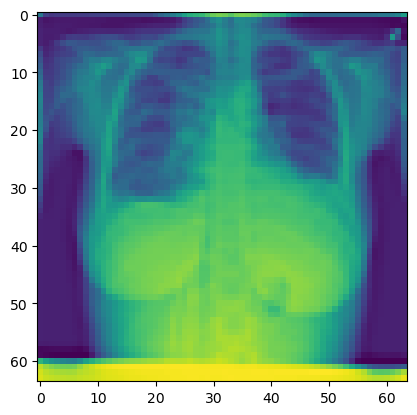

In [61]:
plt.imshow(next(iter(x_train_tf)))

In [36]:
def normalize(image):
    """
    Convert the elements of the tensor into float objects and reshape into a 1D array.
    the command [-1,] means that tf will judge the length of the 1D array. If 'image' has shape (64,64,3), then the newly created
    array will have shape (64*64*3)

    Argument:
    image --Tensor

    Returns: 
    result -- Transformed tensor 
    """
    image = tf.cast(image, tf.float32)
    image = tf.reshape(image,[-1,])

    return image

In [38]:
# normalize the elements of x_train_tf using map
new_x_train = x_train_tf.map(normalize)
new_x_test = x_test_tf.map(normalize)

In [40]:
def one_hot_matrix(labels, depth=4):
    """
    creates one-hot enconding for label 'labels'.

    Arguments:
        labels -- (int) categorical labels (any number from 0 to (depth-1 ))
        depth -- (int) classes for that label

    Return:
        tf.Tensor -- A single column matrix with single one hot encoding 
        (number of column -- labels
        number of row -- depth)
    """

    #one_hot = tf.reshape(tf.one_hot(labels, depth, axis=0),(depth,))
    one_hot = tf.one_hot(labels, depth, axis=-1)

    return one_hot

In [42]:
# Replace each class by a one_hot_matrix
new_y_train = y_train_tf.map(one_hot_matrix)
new_y_test = y_test_tf.map(one_hot_matrix)
# notice that new_y_train will have shape (depth, minibatch_size) [depth from one_hot_matirx]

In [67]:
def initialize_parameters():
    """
    Initializes parameters to build a neural network with TensorFlow. The shapes are:
                        W1 : [25, 4096]
                        b1 : [25, 1]
                        W2 : [12, 25]
                        b2 : [12, 1]
                        W3 : [6, 12]
                        b3 : [6, 1]
    
    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3
    """
    initializer = tf.keras.initializers.GlorotNormal()

    W1 = tf.Variable(initializer(shape = (25, 4096)))
    b1 = tf.Variable(initializer(shape = (25, 1)))
    W2 = tf.Variable(initializer(shape = (12, 25)))
    b2 = tf.Variable(initializer(shape = (12, 1)))
    W3 = tf.Variable(initializer(shape = (4, 12)))
    b3 = tf.Variable(initializer(shape = (4, 1)))

    parameters = {'W1': W1,
                  'b1': b1,
                  'W2': W2,
                  'b2': b2,
                  'W3': W3,
                  'b3': b3}

    return parameters

In [69]:
def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """

    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']

    Z1 = tf.math.add(tf.linalg.matmul(W1, X), b1)
    A1 = tf.keras.activations.relu(Z1)
    Z2 = tf.math.add(tf.linalg.matmul(W2, A1), b2)
    A2 = tf.keras.activations.relu(Z2)
    Z3 = tf.math.add(tf.linalg.matmul(W3, A2), b3)
    
    return Z3

In [71]:
def compute_cost(logits, labels):
    """
    Computes the cost
    
    Arguments:
    logits -- output of forward propagation (output of the last LINEAR unit), of shape (6, num_examples)
    labels -- "true" labels vector, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    # cost function takes as argument 1) the true labels, and 2) the output of forward propagation (the output of the last 
    # linear function Z3 (logits))
    cost = tf.reduce_sum(tf.keras.metrics.categorical_crossentropy(tf.transpose(labels), tf.transpose(logits),from_logits=True))
    # By using from_logits = True, the loss function knows that the inputs are raw logits. So it applys the softmax (for multiclass problem)
    # function to the logits before computing the cost.

    return cost

In [84]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001,
          num_epochs = 1500, minibatch_size = 32, print_cost = True):
    """
    """

    train_acc = []
    test_acc = []
    costs = []

    parameters = initialize_parameters()

    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']

    # define the optimizer
    optimizer_defined = tf.keras.optimizers.Adam(learning_rate)

    # keep track of model accuracy
    test_accuracy = tf.keras.metrics.CategoricalAccuracy()
    train_accuracy = tf.keras.metrics.CategoricalAccuracy()

    # zip the data into a tuple of (input, expected label)
    dataset = tf.data.Dataset.zip((X_train, Y_train))
    test_dataset = tf.data.Dataset.zip((X_test, Y_test))

    # get the number of elements of dataset using the cardiality method
    m = dataset.cardinality().numpy()

    # form minibatches from the dataset
    minibatches = dataset.batch(minibatch_size).prefetch(8)
    test_minibatches = test_dataset.batch(minibatch_size).prefetch(8)

    for epoch in range(num_epochs):
        epoch_cost = 0

        # we need to restart from 0 when start a new epoch
        train_accuracy.reset_state()
        
        for (minibatch_X, minibatch_Y) in minibatches:
            with tf.GradientTape() as tape:
                # predict
                # notice that next(iter(x_train)) has shape (12288,) and  next(iter(x_train.bathc(2))) has shape (2, 12288), 
                # that's why we need the transposr in minibatch_X
                z3 = forward_propagation(tf.transpose(minibatch_X), parameters)

                # cost
                minibatch_cost = compute_cost(z3, tf.transpose(minibatch_Y))
                #print('z3 shape:', z3.shape)
                #print('Y_shape', tf.transpose(minibatch_Y).shape)
                #print(minibatch_Y.shape, z3.shape)

            # update the accuracy of all batches
            train_accuracy.update_state(tf.transpose(z3), minibatch_Y)

            # now use the gradient tape to get the gradients and update the parameters
            trainable_variables = [W1, b1, W2, b2, W3, b3]
            grads = tape.gradient(minibatch_cost, trainable_variables)
            optimizer_defined.apply_gradients(zip(grads, trainable_variables))

            # After applying gradients update the dictionary 'parameters', which is used as an argument to forward_prop
            parameters['W1'], parameters['b1'] = W1, b1
            parameters['W2'], parameters['b2'] = W2, b2
            parameters['W3'], parameters['b3'] = W3, b3

            # add all the costs
            epoch_cost += minibatch_cost

        # we devide the cost of each epoch by number of samples to get the cost per sample
        epoch_cost /= m

        # print cost every 10 epoch
        if print_cost == True and epoch % 10 == 0:
            print("cost after epoch %i: %f" % (epoch, epoch_cost))
            print("train accuracy:", train_accuracy.result())

            for (minibatch_X, minibatch_Y) in test_minibatches:
                Z3 = forward_propagation(tf.transpose(minibatch_X), parameters)
                test_accuracy.update_state(tf.transpose(Z3), minibatch_Y)
            print("Test_accuracy:", test_accuracy.result())

            costs.append(epoch_cost)
            train_acc.append(train_accuracy.result())
            test_acc.append(test_accuracy.result())
            test_accuracy.reset_state() # this resets every 10 epoch

    # Saving the model, after training completes:
    #model_save_path = "covid_classifier_model.h5"  # The path to save the model
    #model.save(model_save_path)  # Save the entire model to a .h5 file
    #print(f"Model saved to {model_save_path}")

    return parameters, costs, train_acc, test_acc

In [ ]:
parameters, costs, train_acc, test_acc = model(new_x_train, new_y_train, new_x_test, new_y_test, num_epochs=20)

cost after epoch 0: 1.101413
train accuracy: tf.Tensor(0.48092368, shape=(), dtype=float32)
Test_accuracy: tf.Tensor(0.5060241, shape=(), dtype=float32)
cost after epoch 10: 0.811321
train accuracy: tf.Tensor(0.66318214, shape=(), dtype=float32)
Test_accuracy: tf.Tensor(0.67564374, shape=(), dtype=float32)


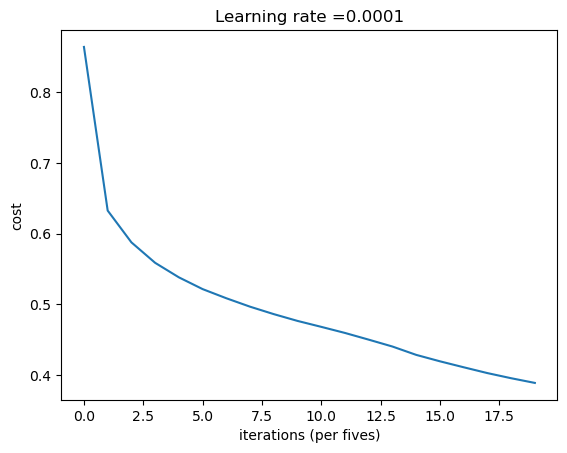

In [65]:
# Plot the cost
plt.plot(np.squeeze(costs))
plt.ylabel('cost')
plt.xlabel('iterations (per fives)')
plt.title("Learning rate =" + str(0.0001))
plt.show()

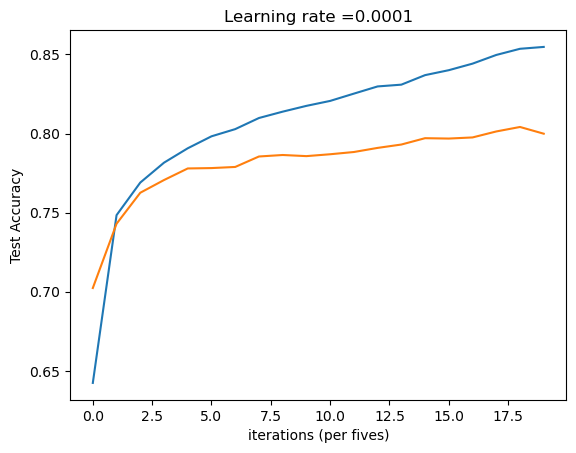

In [67]:
# Plot the train accuracy
plt.plot(np.squeeze(train_acc))
plt.ylabel('Train Accuracy')
plt.xlabel('iterations (per fives)')
plt.title("Learning rate =" + str(0.0001))
# Plot the test accuracy
plt.plot(np.squeeze(test_acc))
plt.ylabel('Test Accuracy')
plt.xlabel('iterations (per fives)')
plt.title("Learning rate =" + str(0.0001))
plt.show()